# Surface Defect Detection

## 1. Introduction

In this notebook, we are going to create a convolutional neural network (CNN) that can detect surface defects.
Previously we have used Torch but now PyTorch will be used.

PyTorch is the freshest flavour of the Torch. It combines customization of Torch with Python ease of use. It completely covers the Torch functionality, on top of that, new Autograd mechanism, dataset loaders and lots of utilities have been added for convenience.

## 2. Code

First, let's import required packages...

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import os
import PIL
%matplotlib inline
plt.ion()

## 2.1 Dataset transformations
PyTorch lets us define a set of transformations to the loaded datasets. 

First images are converted to Torch tensors and then we will be scaling the images to 64 pixels in the smaller dimension. 

In [3]:
baseDirectory = 'g:/Selim/Thesis/Code/PyTorch/'
setDirectory = '3MAll'
setImageSize = 64

# 3MAll set mean and std values
# mean : 0.498283411655
# std : 0.0879390792679
setMean = [0.498, 0.498, 0.498]
setStd = [0.087, 0.087, 0.087]

dataTransforms = {
    'train': transforms.Compose([
        transforms.Scale(setImageSize),
        transforms.CenterCrop(setImageSize),
        transforms.ToTensor(),
        transforms.Normalize(mean=setMean, std=setStd)
    ]),
    'test': transforms.Compose([
        transforms.Scale(setImageSize),
        transforms.CenterCrop(setImageSize),
        transforms.ToTensor(),
        transforms.Normalize(mean=setMean, std=setStd)
    ]),
}

## 2.2 Loading datasets
Unlike Torch, PyTorch now supports direct image folder loading as the data. This completely removes the big dataset preparation step.

Additionally new dataset loaders allow setting batch size, shuffle and several other useful parameters.

Lastly checking the CUDA support is now easier with `torch.cuda.is_available()`

In [3]:
setPath = os.path.join(baseDirectory, setDirectory)
datasets = {x: torchvision.datasets.ImageFolder(os.path.join(setPath, x), dataTransforms[x])
           for x in ['train', 'test']}

datasetLoaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=4, shuffle=True, num_workers=4)
                for x in ['train', 'test']}

testLoader = torch.utils.data.DataLoader(datasets['test'], batch_size=1, shuffle=False, num_workers=4)

datasetSizes = {x: len(datasets[x]) for x in ['train', 'test']}
datasetClasses = datasets['train'].classes

useGPU = torch.cuda.is_available()

print(str(datasetSizes) + ' images will be used.' )
print('GPU will ' + ('' if useGPU else 'not ') + 'be used.' )

{'train': 8950, 'test': 632} images will be used.
GPU will be used.


## 2.3 Auxiliary functions

### 2.3.1 ImShow
Here we define the simple image displaying function and use the new dataset iterator to get one random batch to display it.

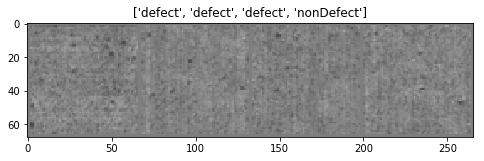

In [4]:
def ImShow(input, title=None):
    input = input.numpy().transpose((1, 2, 0))
    input = setStd * input + setMean
    plt.figure(figsize=(8,8))
    plt.imshow(input)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(datasetLoaders['train']))
out = torchvision.utils.make_grid(inputs)
ImShow(out, title=[datasetClasses[x] for x in classes])

### 2.3.2 VisualizeModel

This function helps displaying the predictions of the network.

In [5]:
def VisualizeModel(model, numImages=6):
    imagesSoFar = 0
    fig = plt.figure()
    
    for i, data in enumerate(datasetLoaders['test']):
        inputs, labels = data
        if useGPU:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            imagesSoFar += 1
            ax = plt.subplot(numImages // 2, 2, imagesSoFar)
            ax.axis('off')
            ax.set_title('Predicted: {}'.format(datasetClasses[labels.data[j]]))
            ImShow(inputs.cpu().data[j])
            
            if imagesSoFar == numImages:
                return

## 2.4 Training functions

This section contains functions used in training the network.

### 2.4.1 TrainModelMiniBatch

Here we have 2 different training functions. First one uses mini batches and a separate learning-rate scheduler function for training.

In [6]:
def TrainModelMiniBatch(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in datasetLoaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if useGPU:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / datasetSizes[phase]
            epoch_acc = running_corrects / datasetSizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

### 2.4.2 TrainModelBatch

This is the previous method of training which uses all of the images in the training set for each training iteration.

In [7]:
def TrainModelBatch(model, criterion, optimizer, lrDecay, maxIteration):
    currentIteration = 0
    startTime = time.time()
    trainSetSize = datasetSizes['train']
    
    shuffledIndices = torch.randperm(trainSetSize)
    print('Started training...')
    
    while True:
        runningLoss = 0
        for iInput, data in enumerate(datasetLoaders['train'], 0):
            inputs, labels = data
            if useGPU:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #print(iInput)
            runningLoss += loss.data[0]
            
        currentError = runningLoss / trainSetSize
        print('Iteration: ' + str(currentIteration) + '# current error = ' + str(currentError))
        currentIteration += 1
        
        if maxIteration > 0 and currentIteration > maxIteration:
            print('# Maximum iteration reached. End of training.')
            print('# Training error = ' + str(currentError))
            timeElapsed = time.time() - startTime            
            print('Training complete in {:.0f}m {:.0f}s'.format(timeElapsed // 60, timeElapsed % 60))
            break


### 2.4.3 ExpLRScheduler

Updates the learning-rate after each `lr_decay_epoch` number of epochs.

In [8]:
def ExpLRScheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    lr = init_lr * (0.1 ** (epoch // lr_decay_epoch))
    
    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    return optimizer

## 2.5 Definition of neural network

### 2.5.1 Network module
Similar to Torch, here we define the neural network using separate modules.
First module handles the convolutional part of the network. After that a reshape operation adjust the convolution result for the following fully-connected layer module. Lastly, the result is applied to the fully-connected layer of the network and decisions are obtained with LogSoftMax operation in the end.

In [9]:
# Currently, weights are not shared.
# TODO: Try weight sharing with looping the element
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
    
        self.outMul = int(setImageSize / 8) 
            
        self.fc = nn.Sequential(
            nn.Linear(32 * self.outMul * self.outMul, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 2)) # number of classes
        
        self.logsmax = nn.LogSoftmax()

    def forward(self, x):
        # Apply inputs to convolutional module of the network
        x = self.conv(x)
        
        # Reshape the result for fully-connected layers
        x = x.view(-1, 32 * self.outMul * self.outMul)
        
        # Apply the result to fully-connected layers
        x = self.fc(x)
        
        # Finally apply the LogSoftMax for output
        x = self.logsmax(x)
        return x

net = Net()
if useGPU:
    net = net.cuda()
        

### 2.5.2 Criterion and optimizer
We successfully created our neural network. Now it is time to define a loss function and the optimizer.

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

if useGPU:
    criterion = criterion.cuda()

## 2.6 Training

Mini-batch training method is preferred with PyTorch. It converges faster than the batch training method.

*Example*

*Mini-batch : With GTX 1070, 10 epochs train in 7m26s with 97.6% train and 97.6% test accuracy.*

*Batch      : With GTX 1070, 10 epochs train in 7m48s with 98.4% train and 96.5% test accuracy.*

In [12]:
TrainModelMiniBatch(net, criterion, optimizer, ExpLRScheduler, num_epochs=10)          

Epoch 0/9
----------
LR is set to 0.001
train Loss: 0.1507 Acc: 0.7141
test Loss: 0.2110 Acc: 0.4541

Epoch 1/9
----------
train Loss: 0.1496 Acc: 0.7151
test Loss: 0.2047 Acc: 0.4541

Epoch 2/9
----------
train Loss: 0.1494 Acc: 0.7151
test Loss: 0.2085 Acc: 0.4541

Epoch 3/9
----------
train Loss: 0.1486 Acc: 0.7151
test Loss: 0.2015 Acc: 0.4541

Epoch 4/9
----------
train Loss: 0.0823 Acc: 0.8560
test Loss: 0.0217 Acc: 0.9684

Epoch 5/9
----------
train Loss: 0.0385 Acc: 0.9474
test Loss: 0.0217 Acc: 0.9731

Epoch 6/9
----------
train Loss: 0.0310 Acc: 0.9613
test Loss: 0.0263 Acc: 0.9620

Epoch 7/9
----------
LR is set to 0.0001
train Loss: 0.0225 Acc: 0.9736
test Loss: 0.0208 Acc: 0.9731

Epoch 8/9
----------
train Loss: 0.0208 Acc: 0.9754
test Loss: 0.0189 Acc: 0.9810

Epoch 9/9
----------
train Loss: 0.0204 Acc: 0.9766
test Loss: 0.0210 Acc: 0.9763

Training complete in 7m 26s
Best val Acc: 0.981013


Net (
  (conv): Sequential (
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU ()
    (5): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU ()
    (8): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (fc): Sequential (
    (0): Linear (2048 -> 4096)
    (1): ReLU ()
    (2): Dropout (p = 0.5)
    (3): Linear (4096 -> 4096)
    (4): ReLU ()
    (5): Dropout (p = 0.5)
    (6): Linear (4096 -> 4096)
    (7): ReLU ()
    (8): Dropout (p = 0.5)
    (9): Linear (4096 -> 2)
  )
  (logsmax): LogSoftmax ()
)

In [19]:
TrainModelBatch(net, criterion, optimizer, 0, maxIteration=10)

Started training...
Iteration: 0# current error = 0.1507318354818408
Iteration: 1# current error = 0.14956322955352633
Iteration: 2# current error = 0.1493570281373722
Iteration: 3# current error = 0.14819697571200366
Iteration: 4# current error = 0.07404888989626268
Iteration: 5# current error = 0.035759027898057974
Iteration: 6# current error = 0.030603457566750834
Iteration: 7# current error = 0.02772999148641568
Iteration: 8# current error = 0.023466098080202526
Iteration: 9# current error = 0.020595020432982124
Iteration: 10# current error = 0.01932157038840759
# Maximum iteration reached. End of training.
# Training error = 0.01932157038840759
Training complete in 7m 48s


## 2.7 Visualization of the weights

This section is still in development.

In [58]:
#VisualizeModel(net)

In [59]:
# IN PROGRESS...
def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
#plot_kernels(net.conv[6].weight.cpu().data.numpy())

In [60]:
import math
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

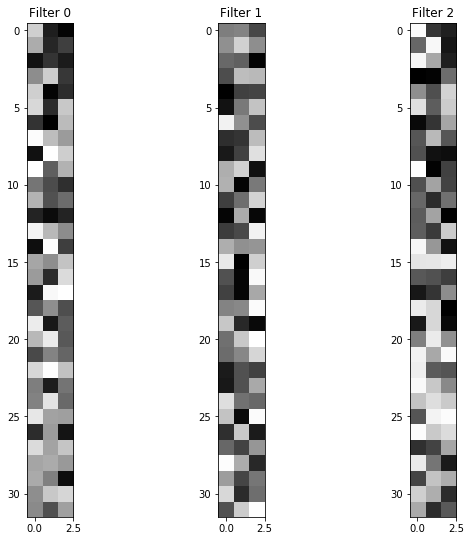

In [61]:
plotNNFilter(net.conv[6].weight.cpu().data.numpy())

## 2.8 Evaluating network accuracy
Let's calculate the accuracy on the training set.

In [20]:
def DetermineAccuracy(phase):
    correct = 0
    total = 0
    for data in datasetLoaders[phase]:
        # Inputs
        inputs, labels = data
        if useGPU:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
    return correct, total

In [21]:
correct, total = DetermineAccuracy('train')
print('Accuracy of the network for training set is {}%'.format(100 * correct / total))

Accuracy of the network for training set is 98.49162011173185%


Now time to see the accuracy of the test set.

In [22]:
correct, total = DetermineAccuracy('test')
print('Accuracy of the network for test set is {}%'.format(100 * correct / total))

Accuracy of the network for test set is 96.51898734177215%


Let's see individual class performance.

In [23]:
classCorrect = list(0. for i in range(2))
classTotal = list(0. for i in range(2))

for i, data in enumerate(testLoader):
    inputs, labels = data
    if useGPU:
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
    
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)

    classTotal[labels.data.cpu().numpy()[0]] += 1
    
    if labels.data.cpu().numpy()[0] == predicted.cpu().numpy()[0][0]:
        classCorrect[labels.data.cpu().numpy()[0]] += 1

for i, cls in enumerate(classCorrect):
    print('Class ' + datasetClasses[i] + ' total: ' + str(classTotal[i]) + ' correct: ' + str(classCorrect[i]) + ' success rate is ' + str(100 * classCorrect[i] / classTotal[i])) 


Class defect total: 345.0 correct: 328.0 success rate is 95.07246376811594
Class nonDefect total: 287.0 correct: 278.0 success rate is 96.86411149825784


Results are looking good, let's save the model for future use.

In [25]:
torch.save(net, 'SurfaceCNN.net')

I:\Anaconda3\envs\PyTorchEnv\lib\site-packages\torch\serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
